# How to do Validation/ Early stopping for Time Series forecasting

This notebook illustrates how one can implement a time series model using PyTorch, and use it together with the rest of the GluonTS ecosystem for data loading, feature processing, and model evaluation.

In [1]:
from typing import List, Optional, Callable
from itertools import islice

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

In [3]:
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.loader import TrainDataLoader, ValidationDataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.torch.batchify import batchify 
from gluonts.torch.support.util import copy_parameters
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.transform import Chain, AddObservedValuesIndicator, InstanceSplitter, ExpectedNumInstanceSampler

For this example we will use the "electricity" dataset, which can be loaded as follows.

In [4]:
dataset = get_dataset("m4_hourly")

In [5]:
# For this notebook, lets take only a subset of the time series 
dataset_train = list(islice(dataset.train, 15))
dataset_test  = list(islice(dataset.test, 15))

In [6]:
prediction_length = dataset.metadata.prediction_length
context_length = prediction_length

### Part 1: "Global model, local validation"
Validation Technique should fit your application!

In [7]:
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))
train_end = train_entry["start"] + pd.Timedelta(value=len(train_entry["target"]), unit="h")
test_end = test_entry["start"] + pd.Timedelta(value=len(test_entry["target"]), unit="h")
start = train_entry["start"]

def plot_dataset(data, is_test, n_series, test_end, train_end=None, validation_date=None, batch=None):    
    date_formater = mdates.DateFormatter('%b, %d')
    fig = plt.figure(figsize=(12,8))
    
    for idx, entry in enumerate(islice(data, n_series)):
        ax = plt.subplot(n_series, 1, idx+1)
        
        # plot train data
        t = pd.date_range(start=entry["start"], end=train_end-pd.Timedelta(value=1, unit="h"), freq=entry["start"].freq)
        plt.plot(t, entry["target"][:len(t)], label = "train")
        
        plt.xlim(entry["start"], test_end)
        
        # plot test data and color the validation data
        if is_test:
            t_test = pd.date_range(start=train_end, end=test_end-pd.Timedelta(value=1, unit="h"), freq=entry["start"].freq)
            plt.plot(t_test, entry["target"][-len(t_test):], color="red", label="test")
            
            if validation_date:
                t_eval = pd.date_range(start=validation_date, end=train_end, freq=entry["start"].freq)
                plt.plot(t_eval, entry["target"][-(len(t_eval)+len(t_test)):-len(t_test)], color="m", label="eval")
        
        # plot batch instances as areas
        if batch:
            for forecast_start, past_target, future_target, instance_id in zip(batch['forecast_start'],
                                                                         batch['past_target'],
                                                                         batch['future_target'], batch['item_id']):
                if(instance_id==idx):
                    t_past = pd.date_range(start=forecast_start-pd.Timedelta(value=prediction_length, unit="h"), end=forecast_start-pd.Timedelta(value=1, unit="h"), freq=start.freq)
                    
                    ax.axvspan(forecast_start-pd.Timedelta(value=prediction_length, unit="h"), forecast_start-pd.Timedelta(value=1, unit="h"), alpha=0.5, color='lightsteelblue')

                    ax.axvspan(forecast_start, forecast_start+pd.Timedelta(value=prediction_length-1, unit="h"), alpha=0.5, color='lightcoral')




        if(idx<n_series-1):
            plt.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    plt.xticks(pd.date_range(start=entry["start"], periods=4, freq="10d"))
    ax.xaxis.set_major_formatter(date_formater)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='right')

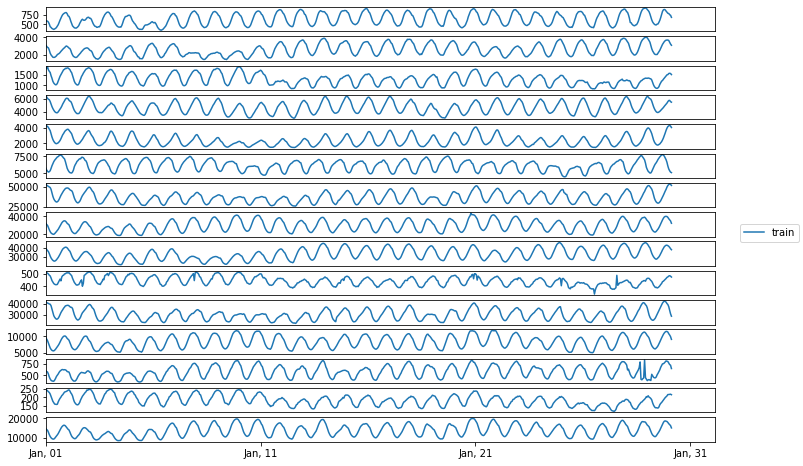

In [8]:
plot_dataset(dataset_train, is_test=False, n_series=15, train_end=train_end, test_end=test_end)

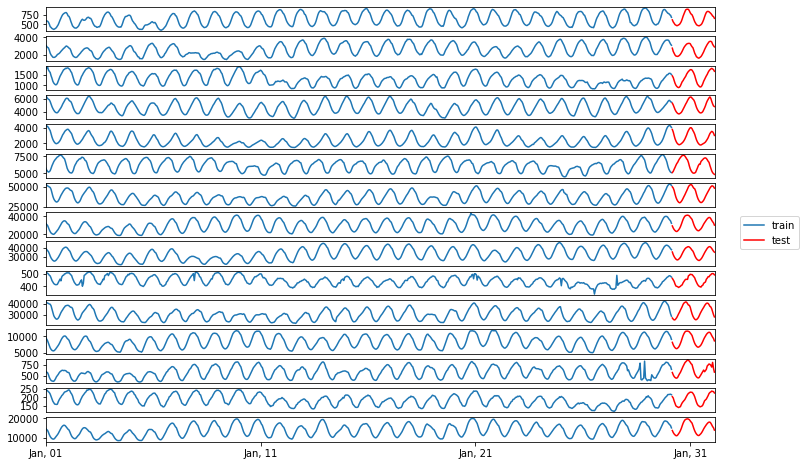

In [9]:
plot_dataset(dataset_test, is_test=True, n_series=15, test_end=test_end, train_end=train_end)

### a reasonable way of doing validation for this prediction task

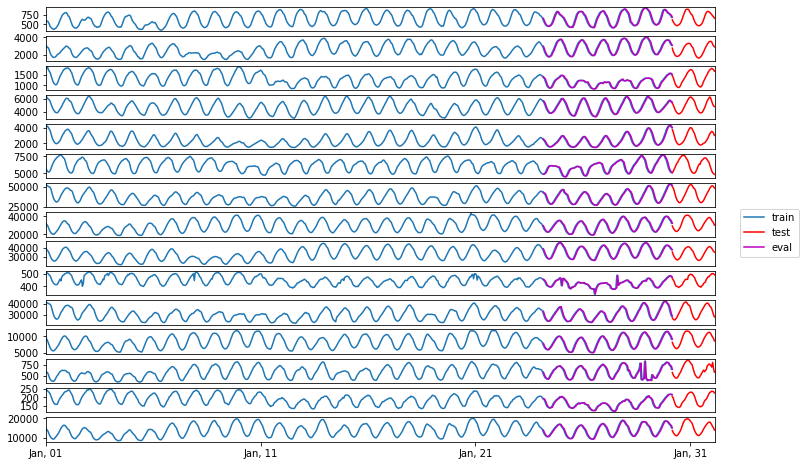

In [10]:
validation_date = train_end - pd.Timedelta(3*prediction_length, unit="h")
plot_dataset(dataset.test, is_test=True, n_series=15, test_end=test_end, train_end=train_end, validation_date=validation_date)

In [11]:
### Defining the dataloader 

In [12]:
# only transformation we employ here is the instance splitter. splits timeseries to get training instances
transformation = InstanceSplitter(
                    target_field=FieldName.TARGET,
                    is_pad_field=FieldName.IS_PAD,
                    start_field=FieldName.START,
                    forecast_start_field=FieldName.FORECAST_START,
                    train_sampler=ExpectedNumInstanceSampler(num_instances=1),
                    past_length=context_length,
                    future_length=prediction_length,
                    dummy_value=0.,
                    pick_incomplete=False
                    
                )

In [13]:
# split of validation dataset from train dataset
n_trainpoints = len(pd.date_range(start, validation_date, freq="h"))-1

dataset_validation = []
for entry in dataset_train:
    
    validation_time_series = entry.copy()
    validation_time_series.update({"start": validation_date-pd.Timedelta(value=context_length, unit="h"), "target": entry["target"][(n_trainpoints-context_length):]})
    dataset_validation.append(validation_time_series)
    
    entry["target"] = entry["target"][:n_trainpoints]




In [14]:
from gluonts.dataset.common import ListDataset
dataset_train = ListDataset(dataset_train, freq="h")
dataset_validation = ListDataset(dataset_validation, freq="h")

In [15]:
from gluonts.torch.batchify import batchify
from functools import partial
training_data_loader = TrainDataLoader(
            dataset=dataset_train,
            transform=transformation,
            batch_size=16,
            num_batches_per_epoch=16,
            stack_fn=partial(batchify, device=torch.device("cpu")))

In [16]:
batch = next(iter(training_data_loader))
len(batch["start"])

16

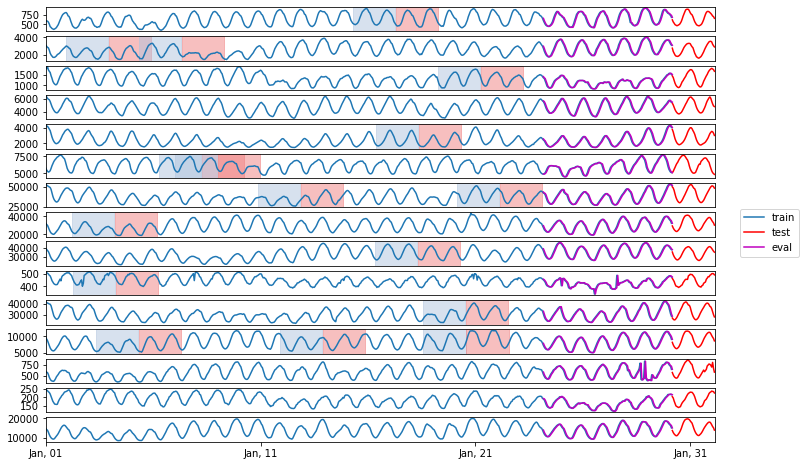

In [17]:
plot_dataset(dataset.test, is_test=True, n_series=15, test_end=test_end, train_end=train_end, validation_date=validation_date, batch=batch)

In [18]:
validation_data_loader = ValidationDataLoader(
            dataset=dataset_validation,
            transform=transformation,
            batch_size = 16,
            stack_fn=partial(batchify, device=torch.device("cpu")))

In [19]:
batch = next(iter(validation_data_loader))


In [20]:
len(batch["start"])

6

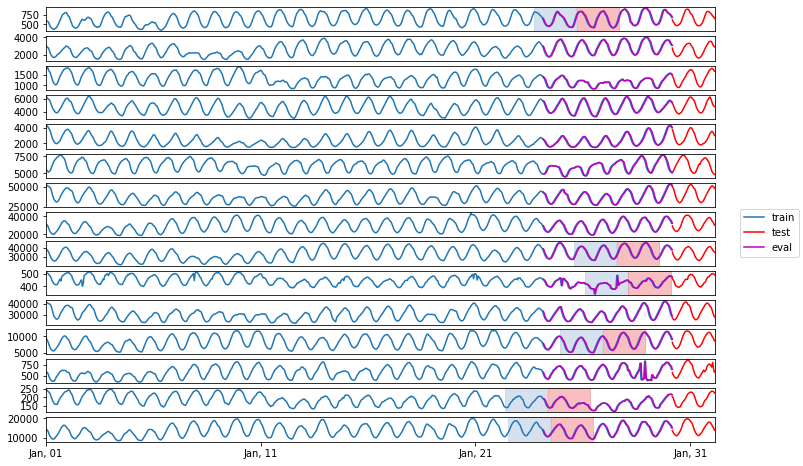

In [21]:
plot_dataset(dataset.test, is_test=True, n_series=15, test_end=test_end, train_end=train_end, validation_date=validation_date, batch=batch)

In [22]:




# plot some batches from the training data loader! (future and past data) which part is calculted 


# validation data laoder! be careful with start date!


#test data loader!




#custom training loop with evaluation and early stopping, calculated on train data
#plot history!!!!!

## Probabilistic feed-forward network using PyTorch

We will use a pretty simple model, based on a feed-forward network whose output layer produces the parameters of a Student's t-distribution at each time step in the prediction range. We will define two networks based on this idea:
* The `TrainingFeedForwardNetwork` computes the loss associated with given observations, i.e. the negative log-likelihood of the observations according to the output distribution; this will be used during training.
* The `SamplingFeedForwardNetwork` will be used at inference time: this uses the output distribution to draw a sample of a given size, as a way to encode the predicted distribution.

In [23]:
def mean_abs_scaling(context, min_scale=1e-5):
    return context.abs().mean(1).clamp(min_scale, None).unsqueeze(1)

In [24]:
def no_scaling(context):
    return torch.ones(context.shape[0], 1)

In [25]:
class TrainingFeedForwardNetwork(nn.Module):
    distr_type = torch.distributions.StudentT
    
    def __init__(
        self,
        prediction_length: int,
        context_length: int,
        hidden_dimensions: List[int],
        batch_norm: bool=False,
        scaling: Callable=mean_abs_scaling,
    ) -> None:
        super().__init__()
        
        assert prediction_length > 0
        assert context_length > 0
        assert len(hidden_dimensions) > 0
        
        self.prediction_length = prediction_length
        self.context_length = context_length
        self.hidden_dimensions = hidden_dimensions
        self.batch_norm = batch_norm
        self.scaling = scaling
        
        dimensions = [context_length] + hidden_dimensions[:-1]

        modules = []
        for in_size, out_size in zip(dimensions[:-1], dimensions[1:]):
            modules += [self.__make_lin(in_size, out_size), nn.ReLU()]
            if batch_norm:
                modules.append(nn.BatchNorm1d(units))
        modules.append(self.__make_lin(dimensions[-1], prediction_length * hidden_dimensions[-1]))
        self.nn = nn.Sequential(*modules)
        
        self.df_proj = nn.Sequential(self.__make_lin(hidden_dimensions[-1], 1), nn.Softplus())
        self.loc_proj = self.__make_lin(hidden_dimensions[-1], 1)
        self.scale_proj = nn.Sequential(self.__make_lin(hidden_dimensions[-1], 1), nn.Softplus())
    
    @staticmethod
    def __make_lin(dim_in, dim_out):
        lin = nn.Linear(dim_in, dim_out)
        torch.nn.init.uniform_(lin.weight, -0.07, 0.07)
        torch.nn.init.zeros_(lin.bias)
        return lin
    
    def distr_and_scale(self, context):
        scale = self.scaling(context)
        scaled_context = context / scale
        nn_out = self.nn(scaled_context)
        nn_out_reshaped = nn_out.reshape(-1, self.prediction_length, self.hidden_dimensions[-1])
        
        distr_args = (
            2.0 + self.df_proj(nn_out_reshaped).squeeze(dim=-1),
            self.loc_proj(nn_out_reshaped).squeeze(dim=-1),
            self.scale_proj(nn_out_reshaped).squeeze(dim=-1),
        )
        distr = net.distr_type(*distr_args)
        
        return distr, scale
    
    def forward(self, context, target):
        assert context.shape[-1] == self.context_length
        assert target.shape[-1] == self.prediction_length
        
        distr, scale = self.distr_and_scale(context)
        loss = (-distr.log_prob(target / scale) + torch.log(scale)).mean(dim=1)
        
        return loss

In [26]:
class SamplingFeedForwardNetwork(TrainingFeedForwardNetwork):
    def __init__(self, *args, num_samples: int = 1000, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_samples = num_samples
        
    def forward(self, context):
        assert context.shape[-1] == self.context_length
        
        distr, scale = self.distr_and_scale(context)
        sample = distr.sample((self.num_samples, )) * scale
        
        return sample.permute(1, 0, 2)

We can now instantiate the training network, and explore its set of parameters.

In [27]:
context_length = 2 * 7 * 24
prediction_length = dataset.metadata.prediction_length
hidden_dimensions = [96, 48]

In [28]:
batch_size = 32
num_batches_per_epoch = 100

In [29]:
net = TrainingFeedForwardNetwork(
    prediction_length=prediction_length,
    context_length=context_length,
    hidden_dimensions=hidden_dimensions,
    batch_norm=False,
    scaling=mean_abs_scaling,
)

In [30]:
sum(np.prod(p.shape) for p in net.parameters())

255987

In [31]:
for p in net.parameters():
    print(p.shape)

torch.Size([96, 336])
torch.Size([96])
torch.Size([2304, 96])
torch.Size([2304])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])
torch.Size([1, 48])
torch.Size([1])


## Defining the training data loader

We now set up the data loader which will yield batches of data to train on. Starting from the original dataset, the data loader is configured to apply the following transformation, which does essentially two things:
* Replaces `nan`s in the target field with a dummy value (zero), and adds a field indicating which values were actually observed vs imputed this way.
* Slices out training instances of a fixed length randomly from the given dataset; these will be stacked into batches by the data loader itself.

In [32]:
transformation = Chain([
    AddObservedValuesIndicator(
        target_field=FieldName.TARGET,
        output_field=FieldName.OBSERVED_VALUES,
    ),
    InstanceSplitter(
        target_field=FieldName.TARGET,
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        train_sampler=ExpectedNumInstanceSampler(num_instances=1),
        past_length=context_length,
        future_length=prediction_length,
        time_series_fields=[FieldName.OBSERVED_VALUES],
    ),
])

In [33]:
data_loader = TrainDataLoader(
    dataset.train,
    batch_size=batch_size,
    stack_fn=batchify,
    transform=transformation,
    num_batches_per_epoch=num_batches_per_epoch
)

## Train the model

We can now train the model using any of the available optimizers from PyTorch:

In [34]:
optimizer = torch.optim.Adam(net.parameters())

for epoch_no in range(10):
    sum_epoch_loss = 0.0
    for batch_no, batch in enumerate(data_loader, start=1):
        optimizer.zero_grad()

        context = batch["past_target"]
        target = batch["future_target"]
        loss_vec = net(context, target)
        loss = loss_vec.mean()
        loss.backward()
        
        optimizer.step()
        
        sum_epoch_loss += loss.detach().numpy().item()
        
    print(f"{epoch_no}: {sum_epoch_loss / num_batches_per_epoch}")

0: 5.585243566036224
1: 4.81437451839447
2: 4.526271158456803
3: 4.716450816392898
4: 4.572400034666061
5: 4.4443921935558315
6: 4.522033716440201
7: 4.434141848087311
8: 4.693082166910171
9: 4.322701251506805


## Create predictor out of the trained model, and test it

We now have a trained model, whose parameters can be copied over to a `SamplingFeedForwardNetwork` object: we will wrap this into a `PyTorchPredictor` that can be used for inference tasks.

In [35]:
pred_net = SamplingFeedForwardNetwork(
    prediction_length=net.prediction_length,
    context_length=net.context_length,
    hidden_dimensions=net.hidden_dimensions,
    batch_norm=net.batch_norm,
)
copy_parameters(net, pred_net)

predictor_pytorch = PyTorchPredictor(
    prediction_length=prediction_length, freq = dataset.metadata.freq, 
    input_names = ["past_target"], prediction_net=pred_net, batch_size=32, input_transform=transformation,
    device=None
)

For example, we can do backtesting on the test dataset: in what follows, `make_evaluation_predictions` will slice out the trailing `prediction_length` observations from the test time series, and use the given predictor to obtain forecasts for the same time range.

In [36]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor_pytorch,
    num_samples=1000,
)

forecasts_pytorch = list(forecast_it)
tss_pytorch = list(ts_it)

Once we have the forecasts, we can plot them:

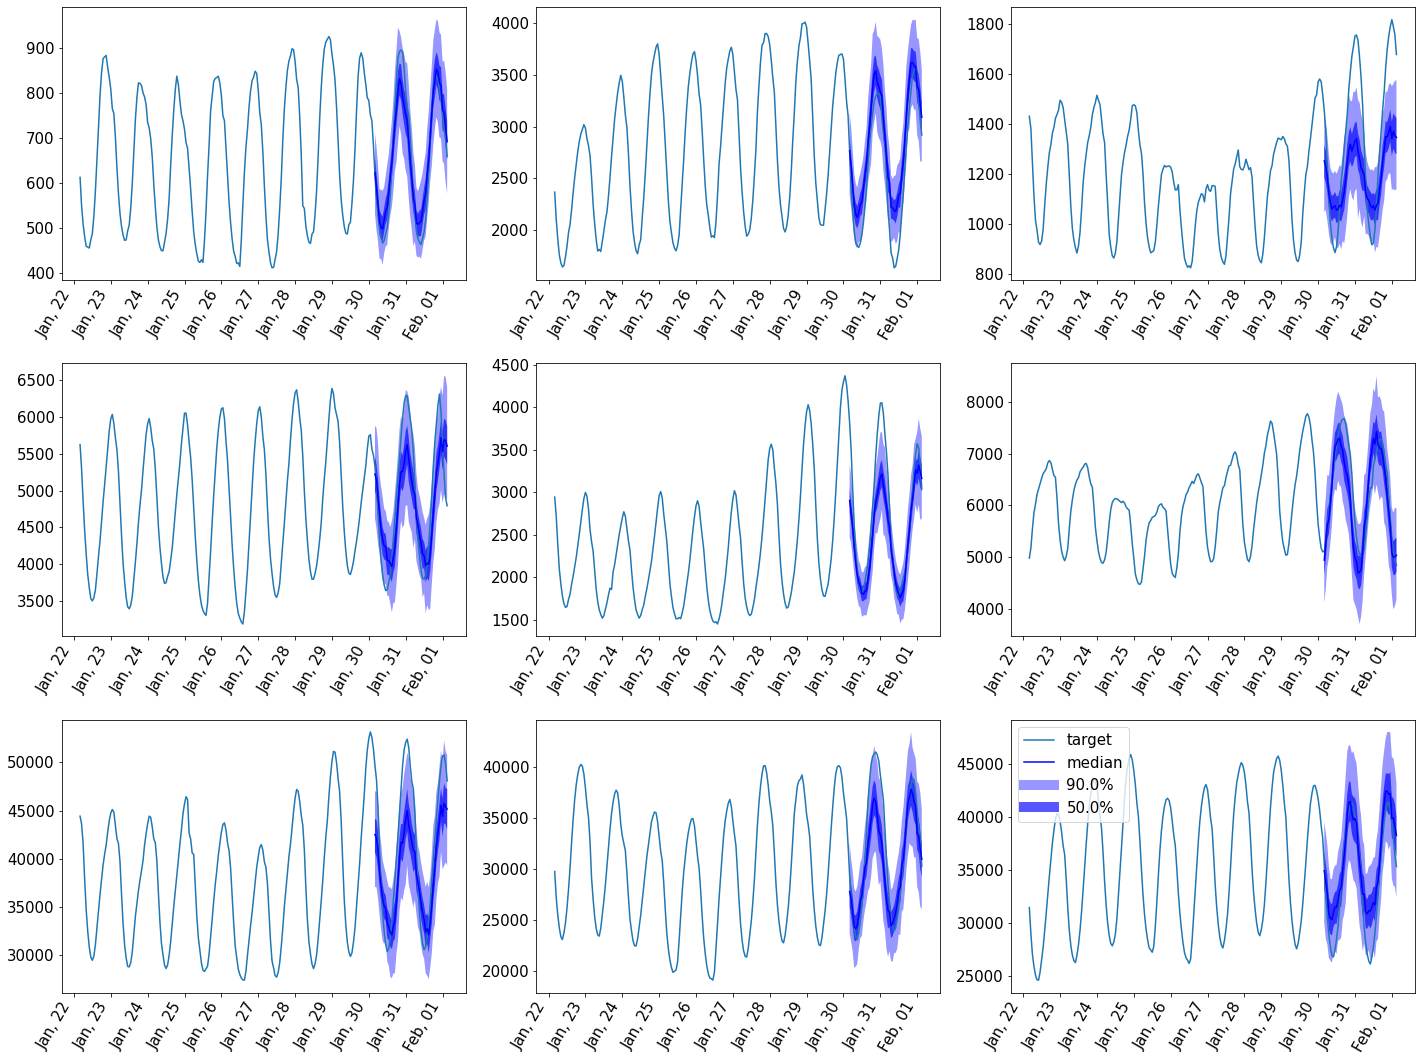

In [37]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts_pytorch, tss_pytorch)), 9):
    ax =plt.subplot(3, 3, idx+1)
    
    plt.plot(ts[-5 * prediction_length:], label="target")
    forecast.plot()
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    
plt.gcf().tight_layout()
plt.legend()
plt.show()

And we can compute evaluation metrics, that summarize the performance of the model on our test data.

In [38]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

In [39]:
metrics_pytorch, _ = evaluator(iter(tss_pytorch), iter(forecasts_pytorch), num_series=len(dataset.test))
pd.DataFrame.from_records(metrics_pytorch, index=["FeedForward"]).transpose()

Running evaluation: 100%|██████████| 414/414 [00:00<00:00, 6697.19it/s]


,FeedForward
Coverage[0.1],8.574879e-02
Coverage[0.5],3.740942e-01
Coverage[0.9],8.296598e-01
MAE_Coverage,7.016573e-02
MAPE,2.068630e-01
MASE,4.974955e+00
MSE,8.095276e+06
MSIS,3.236263e+01
ND,6.660640e-02
NRMSE,3.884354e-01


### Global validation